In [1]:
# Cell 1: imports & config
from pathlib import Path
import json, time, math
from pprint import pprint
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# ----- USER CONFIG -----
ROOT = Path.cwd().parent           # adjust if notebook sits somewhere else
EMB_ROOT = ROOT / "embeddings"     # embeddings/<split>/<video_stem>.npy
LABELS_JSON = ROOT / "data" / "labels.json"
CHECKPOINT_DIR = ROOT / "checkpoints"
SPATIAL_CKPT = CHECKPOINT_DIR / "spatial" / "spatial_best_valAUC.pth"
TEMPORAL_CKPT = CHECKPOINT_DIR / "temporal" / "temporal_best_valAUC.pth"
OUT_DIR = ROOT / "ensemble_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
print("Embeddings root:", EMB_ROOT)
print("Spatial ckpt:", SPATIAL_CKPT)
print("Temporal ckpt:", TEMPORAL_CKPT)
print("Output dir:", OUT_DIR)

Device: cuda
Embeddings root: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\embeddings
Spatial ckpt: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\spatial\spatial_best_valAUC.pth
Temporal ckpt: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\checkpoints\temporal\temporal_best_valAUC.pth
Output dir: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_outputs


In [2]:
# Cell 2: helper to load state dict robustly (prints missing/unexpected)
def safe_load_state_dict(model, state_dict):
    """
    Try to load state into model with strict=False and print diagnostics.
    Returns (missing_keys, unexpected_keys).
    """
    res = model.load_state_dict(state_dict, strict=False)
    missing = res.missing_keys if hasattr(res, "missing_keys") else res[0]
    unexpected = res.unexpected_keys if hasattr(res, "unexpected_keys") else res[1]
    print("safe_load_state_dict: missing keys (maybe ok):", missing)
    print("safe_load_state_dict: unexpected keys (maybe ok):", unexpected)
    return missing, unexpected

In [3]:
# Cell 3: model definitions (mirror your training code)
import timm  # you said you installed timm already

class SpatialModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b3", pretrained=False, head_hidden=512, dropout=0.4):
        super().__init__()
        # create backbone exactly the same as training (num_classes=0)
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features
        # identical head to your train_spatial
        self.head = nn.Sequential(
            nn.Linear(feat_dim, head_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1)  # logits
        )

    def forward(self, x):
        # if x are images: run backbone then head
        feats = self.backbone(x)
        logits = self.head(feats).squeeze(1)
        return logits

class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.att = nn.Linear(hidden_dim, 1)
    def forward(self, h, lengths):
        # h: [B, T, H]
        scores = self.att(h).squeeze(-1)  # [B, T]
        mask = torch.arange(h.size(1), device=h.device).unsqueeze(0) >= lengths.unsqueeze(1)
        scores = scores.masked_fill(mask, float("-1e9"))
        weights = torch.softmax(scores, dim=1)
        out = (h * weights.unsqueeze(-1)).sum(dim=1)
        return out, weights

class TemporalModel(nn.Module):
    def __init__(self, feat_dim, LSTM_HIDDEN=512, LSTM_LAYERS=2, BIDIRECTIONAL=True, DROPOUT=0.3):
        super().__init__()
        self.lstm = nn.LSTM(feat_dim, LSTM_HIDDEN, LSTM_LAYERS,
                            batch_first=True, bidirectional=BIDIRECTIONAL,
                            dropout=DROPOUT if LSTM_LAYERS > 1 else 0)
        out_dim = LSTM_HIDDEN * (2 if BIDIRECTIONAL else 1)
        self.attn = AttentionPool(out_dim)
        self.head = nn.Sequential(nn.Linear(out_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256,1))
    def forward(self, x, lengths):
        # slicing/sorting/packing as in your notebook
        if not isinstance(lengths, torch.Tensor):
            lengths = torch.tensor(lengths, device=x.device, dtype=torch.long)
        lengths_sorted, perm_idx = lengths.sort(descending=True)
        x_sorted = x[perm_idx]
        packed = rnn_utils.pack_padded_sequence(x_sorted, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, _ = self.lstm(packed)
        out_unpacked, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        _, unperm_idx = perm_idx.sort()
        out = out_unpacked[unperm_idx]
        lengths = lengths[unperm_idx]
        pooled, att_weights = self.attn(out, lengths)
        logits = self.head(pooled).squeeze(1)
        if att_weights is not None:
            att_weights = att_weights[unperm_idx]
        return logits, att_weights

In [4]:
# Cell 4: load checkpoints (defensive)
# Instantiate models (don't request pretrained to avoid extra downloads)
# We'll set pretrained=False here since we will load your checkpoint weights.
spatial_model = SpatialModel(pretrained=False).to(DEVICE)
temporal_model = None
if TEMPORAL_CKPT.exists():
    # We need to know feat_dim for temporal model; we will infer from an embedding file later.
    pass

# Load spatial checkpoint if present
if SPATIAL_CKPT.exists():
    ck = torch.load(SPATIAL_CKPT, map_location="cpu")
    state = ck.get("model_state", ck)
    print("Loaded spatial checkpoint keys sample (first 10):", list(state.keys())[:10])
    missing, unexpected = safe_load_state_dict(spatial_model, state)
    spatial_model.to(DEVICE).eval()
else:
    print("Spatial checkpoint missing at:", SPATIAL_CKPT)
    # we still can use spatial head if you have 'spatial_head.pth' separately, but for now warn:
    raise FileNotFoundError(f"Spatial checkpoint not found: {SPATIAL_CKPT}")

# We'll load temporal_model after we know FEAT_DIM (next cell).
print("Spatial model ready (head available).")

Loaded spatial checkpoint keys sample (first 10): ['backbone.conv_stem.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.blocks.0.0.conv_dw.weight', 'backbone.blocks.0.0.bn1.weight', 'backbone.blocks.0.0.bn1.bias', 'backbone.blocks.0.0.bn1.running_mean']
safe_load_state_dict: missing keys (maybe ok): []
safe_load_state_dict: unexpected keys (maybe ok): []
Spatial model ready (head available).


In [5]:
# Cell 5: discover feat dim from embeddings and create temporal model
# find a sample embedding file
def find_sample_embedding(split="train"):
    d = EMB_ROOT / split
    if not d.exists():
        return None
    for p in d.glob("*.npy"):
        return p
    return None

sample = find_sample_embedding("train") or find_sample_embedding("val") or find_sample_embedding("test")
if sample is None:
    raise FileNotFoundError("No embedding files found in embeddings/ -- run extract_embeddings first.")
arr = np.load(sample)
FEAT_DIM = int(arr.shape[1])
print("Sample embedding:", sample, "feat dim:", FEAT_DIM)
# instantiate temporal model now
temporal_model = TemporalModel(feat_dim=FEAT_DIM).to(DEVICE)
if TEMPORAL_CKPT.exists():
    ck = torch.load(TEMPORAL_CKPT, map_location="cpu")
    state = ck.get("model_state", ck)
    print("Loaded temporal checkpoint keys sample (first 10):", list(state.keys())[:10])
    safe_load_state_dict(temporal_model, state)
    temporal_model.to(DEVICE).eval()
    print("Temporal model loaded.")
else:
    print("Temporal checkpoint not found; temporal logits will not be generated.")

Sample embedding: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\embeddings\train\000.npy feat dim: 1536
Loaded temporal checkpoint keys sample (first 10): ['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1']
safe_load_state_dict: missing keys (maybe ok): []
safe_load_state_dict: unexpected keys (maybe ok): []
Temporal model loaded.


In [6]:
# Cell 6: generate CSVs from embeddings + models
# CSVs will be placed in OUT_DIR: features_train.csv, features_val.csv, features_test.csv
splits = ["train", "val", "test"]
all_dfs = {}

def stem_label(stem):
    with open(LABELS_JSON, "r") as f:
        lm = json.load(f)
    if stem in lm:
        return int(lm[stem])
    # fallback to substring match if necessary
    for k,v in lm.items():
        if stem in k:
            return int(v)
    raise KeyError(f"Label for stem {stem} not found in labels.json")

for split in splits:
    rows = []
    d = EMB_ROOT / split
    if not d.exists():
        print("Skipping missing split:", split)
        continue
    files = sorted(list(d.glob("*.npy")))
    print(f"Processing {len(files)} files in split={split}")
    for p in tqdm(files):
        stem = p.stem
        try:
            emb = np.load(p)  # (T, feat)
        except Exception as e:
            print("Failed to load", p, e)
            continue
        if emb.size == 0 or emb.ndim != 2:
            print("Bad embedding shape:", p, emb.shape)
            continue

        label = stem_label(stem)
        # compute spatial logits/probs using spatial_model.head (we have backbone outputs saved as embeddings)
        # Move to device in batch and avoid grad
        t = torch.from_numpy(emb.astype(np.float32)).to(DEVICE)
        with torch.no_grad():
            # head expects shape [T, feat] and outputs [T] logits
            logits = spatial_model.head(t).squeeze(1)    # use head directly (faster)
            # handle case head returned shape [T,1] or [T]
            if logits.dim() == 2 and logits.size(1) == 1:
                logits = logits.squeeze(1)
            probs = torch.sigmoid(logits)
            logits_np = logits.cpu().numpy()
            probs_np = probs.cpu().numpy()

        # spatial stats
        sp_mean_prob = float(np.nanmean(probs_np))
        sp_max_prob = float(np.nanmax(probs_np))
        sp_median_prob = float(np.nanmedian(probs_np))
        sp_std_prob = float(np.nanstd(probs_np))
        sp_mean_logit = float(np.nanmean(logits_np))

        # temporal score: run temporal_model if available. we give it full sequence and lengths
        tmp_logit = float("nan")
        if temporal_model is not None:
            # pad to single batch and call model
            seq = torch.from_numpy(emb.astype(np.float32)).unsqueeze(0).to(DEVICE)  # [1, T, feat]
            lengths = torch.tensor([emb.shape[0]], dtype=torch.long).to(DEVICE)
            with torch.no_grad():
                tlogit, _ = temporal_model(seq, lengths)
                # tlogit is tensor of shape [1]
                tmp_logit = float(tlogit.detach().cpu().item())

        rows.append({
            "split": split,
            "stem": stem,
            "label": int(label),
            "tmp_logit": tmp_logit,
            "sp_mean_prob": sp_mean_prob,
            "sp_max_prob": sp_max_prob,
            "sp_median_prob": sp_median_prob,
            "sp_std_prob": sp_std_prob,
            "sp_mean_logit": sp_mean_logit,
            "num_frames": emb.shape[0]
        })

    df = pd.DataFrame(rows)
    all_dfs[split] = df
    outp = OUT_DIR / f"features_{split}.csv"
    df.to_csv(outp, index=False)
    print("Wrote", outp, "shape:", df.shape)

# quick shapes
for k,v in all_dfs.items():
    print(k, "shape:", v.shape)

Processing 4066 files in split=train


100%|██████████| 4066/4066 [00:12<00:00, 335.40it/s]


Wrote c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_outputs\features_train.csv shape: (4066, 10)
Processing 761 files in split=val


100%|██████████| 761/761 [00:02<00:00, 337.44it/s]


Wrote c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_outputs\features_val.csv shape: (761, 10)
Processing 255 files in split=test


100%|██████████| 255/255 [00:00<00:00, 339.27it/s]

Wrote c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_outputs\features_test.csv shape: (255, 10)
train shape: (4066, 10)
val shape: (761, 10)
test shape: (255, 10)


In [7]:
# Cell 7: combine and quick sanity checks
dfs = []
for s in splits:
    if s in all_dfs:
        dfs.append(all_dfs[s])
big = pd.concat(dfs, ignore_index=True)
print("Combined DF shape:", big.shape)
print(big.head())
# check labels
print("Label counts:\n", big.groupby("split")["label"].value_counts())

Combined DF shape: (5082, 10)
   split     stem  label  tmp_logit  sp_mean_prob  sp_max_prob  \
0  train      000      1   6.997919      0.948205     0.994730   
1  train  000_003      1  10.571057      0.995534     1.000000   
2  train      001      0 -12.161186      0.036469     0.289718   
3  train      003      0 -12.892393      0.000001     0.000010   
4  train  003_000      1  11.199828      0.999729     1.000000   

   sp_median_prob  sp_std_prob  sp_mean_logit  num_frames  
0    9.796171e-01     0.088707       3.793337           8  
1    9.985341e-01     0.005364       9.684116           8  
2    3.408732e-07     0.095721     -12.066820           8  
3    3.090559e-14     0.000003     -30.492195           8  
4    9.999961e-01     0.000662      14.154212           8  
Label counts:
 split  label
test   0         131
       1         124
train  0        2085
       1        1981
val    0         404
       1         357
Name: count, dtype: int64


In [8]:
# Cell 8: train ensemble classifier (using train/val/test splits from CSVs generated)
# We'll train on train split and use val split for calibration (Platt)
train_df = all_dfs.get("train")
val_df = all_dfs.get("val")
test_df = all_dfs.get("test")

# features to use
FEATURES = ["sp_mean_prob", "sp_max_prob", "sp_median_prob", "sp_std_prob", "sp_mean_logit", "tmp_logit"]

def prepare_Xy(df):
    X = df[FEATURES].copy()
    # handle NaNs: tmp_logit may be NaN if temporal model missing -> fill with 0
    X = X.fillna(0.0)
    y = df["label"].values
    return X.values, y

X_train, y_train = prepare_Xy(train_df)
X_val, y_val = prepare_Xy(val_df)
X_test, y_test = prepare_Xy(test_df)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)

# Base logistic regression (liblinear or saga depending size)
base_clf = LogisticRegression(max_iter=2000, solver="lbfgs")
base_clf.fit(X_train, y_train)
train_pred = base_clf.predict_proba(X_train)[:,1]
val_pred = base_clf.predict_proba(X_val)[:,1]
test_pred = base_clf.predict_proba(X_test)[:,1]

print("Base Train AUC:", roc_auc_score(y_train, train_pred))
print("Base Val   AUC:", roc_auc_score(y_val, val_pred))
print("Base Test  AUC:", roc_auc_score(y_test, test_pred))

# Calibrate on val set (Platt scaling)
cal = CalibratedClassifierCV(base_clf, method="sigmoid", cv="prefit")
cal.fit(X_val, y_val)   # fit calibrator on val set
train_pred_cal = cal.predict_proba(X_train)[:,1]
val_pred_cal = cal.predict_proba(X_val)[:,1]
test_pred_cal = cal.predict_proba(X_test)[:,1]

print("Calibrated Train AUC:", roc_auc_score(y_train, train_pred_cal))
print("Calibrated Val   AUC:", roc_auc_score(y_val, val_pred_cal))
print("Calibrated Test  AUC:", roc_auc_score(y_test, test_pred_cal))

# Save models & preds & csvs
import joblib
joblib.dump(base_clf, OUT_DIR / "ensemble_base_lr.pkl")
joblib.dump(cal, OUT_DIR / "ensemble_calibrated.pkl")
train_df_out = train_df.copy()
train_df_out["ens_prob_base"] = train_pred
train_df_out["ens_prob_cal"] = train_pred_cal
train_df_out.to_csv(OUT_DIR/"ensemble_train_preds.csv", index=False)
val_df_out = val_df.copy()
val_df_out["ens_prob_base"] = val_pred
val_df_out["ens_prob_cal"] = val_pred_cal
val_df_out.to_csv(OUT_DIR/"ensemble_val_preds.csv", index=False)
test_df_out = test_df.copy()
test_df_out["ens_prob_base"] = test_pred
test_df_out["ens_prob_cal"] = test_pred_cal
test_df_out.to_csv(OUT_DIR/"ensemble_test_preds.csv", index=False)

print("Saved ensemble models and CSV predictions to", OUT_DIR)

c:\Users\lkmah\AppData\Local\Programs\anaconda3\envs\aiml\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Train shape: (4066, 6) Val shape: (761, 6) Test shape: (255, 6)
Base Train AUC: 0.9999995157836375
Base Val   AUC: 0.9945988296308623
Base Test  AUC: 0.9902117704998769
Calibrated Train AUC: 0.9999995157836375
Calibrated Val   AUC: 0.9945988296308623
Calibrated Test  AUC: 0.9902117704998769
Saved ensemble models and CSV predictions to c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_outputs


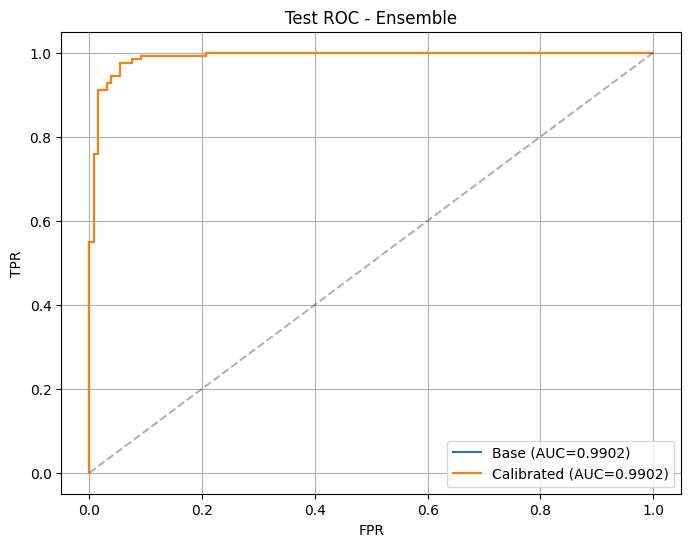

In [9]:
# Cell 9: ROC plots
def plot_roc(y_true, y_score, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return fpr, tpr

plt.figure(figsize=(8,6))
fpr, tpr = plot_roc(y_test, test_pred, "base")
plt.plot(fpr, tpr, label=f"Base (AUC={roc_auc_score(y_test,test_pred):.4f})")
fpr2, tpr2 = plot_roc(y_test, test_pred_cal, "cal")
plt.plot(fpr2, tpr2, label=f"Calibrated (AUC={roc_auc_score(y_test,test_pred_cal):.4f})")
plt.plot([0,1],[0,1],"k--",alpha=0.3)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Test ROC - Ensemble")
plt.legend(); plt.grid(True)
plt.show()

In [10]:
# Cell 10: summary
print("Saved outputs to:", OUT_DIR)
print("Final calibrated Test AUC:", roc_auc_score(y_test, test_pred_cal))
print("You can inspect CSVs: ensemble_*_preds.csv in the folder above.")

Saved outputs to: c:\Users\lkmah\OneDrive\Desktop\Lokesh\VS Code\DeepFake_Detection_SIC\ensemble_outputs
Final calibrated Test AUC: 0.9902117704998769
You can inspect CSVs: ensemble_*_preds.csv in the folder above.
